In [1]:
using Plots
using LinearAlgebra
using Distributions
using Statistics

In [89]:
function MHRW(energia,np,p0,δ=0.5,iterations=10000)
    
    
    #Muestras del algorimo
    samples = zeros(np,iterations)
    allsamples = zeros(np,iterations,2)
    
    #Punto de partida
    ## Se escoge el punto inicial 
    samples[:,1] = p0
    allsamples[:,1,1] = p0
    allsamples[:,1,2] = p0
    
    #Probabilidades
    probabilities = zeros(iterations)
    probabilities[1] = energia(samples[:,1])
    
    #Tasa de aceptación
    rateAlpha = 0
    
    # Algoritmo Metrópolis-Hastings
    for i in 1:iterations-1
        
        #Estado actual
        Xᵢ = samples[:,i]
        #Estado propuesto
        X₊ = rand(MvNormal(Xᵢ,δ*I))

        allsamples[:,i+1,2] = X₊
        
        #π(Estado actual → Estado propuesto)
        pXᵢX₊ = energia(X₊) * pdf(MvNormal(Xᵢ,δ*I),X₊)
        #π(Estado propuesto → Estado actual)
        pX₊Xᵢ = energia(Xᵢ) * pdf(MvNormal(X₊,δ*I),Xᵢ)
        #Tasa de aceptacion α
        if pX₊Xᵢ > 0
            alpha = min(1, pXᵢX₊/pX₊Xᵢ)
        else 
            alpha = 0
        end
    
        #Aceptación o rechazo del estado propuesto
        u = rand()    
        if u < alpha 				#Aceptación
            allsamples[:,i+1,1] = X₊
            samples[:,i+1] = X₊
            probabilities[i+1] = energia(X₊)
            rateAlpha += 1
        else 						#Rechazo
            allsamples[:,i+1,1] = Xᵢ
            samples[:,i+1] = Xᵢ
            probabilities[i+1] = energia(Xᵢ)
        end
    end
    rateAlpha /= (iterations-1)
    MAP = samples[:,findmax(probabilities)[2]]
    CM = [mean(row) for row in eachrow(samples)]
    return samples, allsamples, probabilities, MAP, CM, rateAlpha
end

MHRW (generic function with 3 methods)

In [138]:
function MCIntegration(s)
    n = length(s)
    integral = zeros(n)
    convergence = zeros(n-1)
    for i in 1:n
        integral[i] = mean(s[1:i])
    end
    for j in 2:n
        convergence[j-1] = norm(integral[j]-integral[j-1])
    end
    A = [ones(n-1) log.(1:n-1) ]
    #rate = (A' * A + 0.001*I) \ (A' * log.(convergence .+ 0.001))
    rate = A \ log.(convergence .+ 1E-8)
    return convergence, rate[2]
end

MCIntegration (generic function with 1 method)

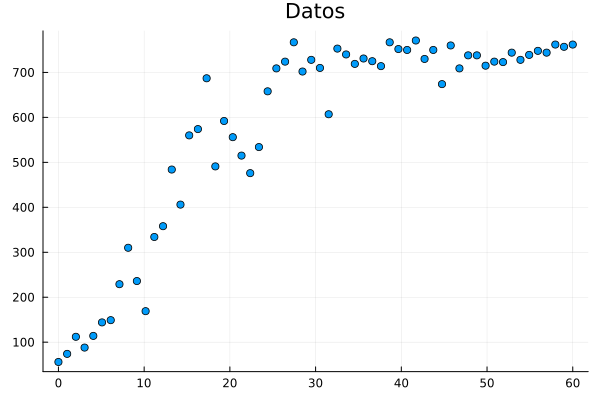

In [111]:
N = 60

function sol_analitica(p)
    x₀ = 50
    r = p[1]
    K = 1000*p[2]
    Tiempo = range(1.0, 60.0, length=N)
    return x₀ * K ./ (x₀ .+ (K - x₀) * exp.(-r * Tiempo) )
end


Crecimiento = zeros(N)
for l in 1:N
    r₀ = rand(Beta(25,100)) 
    K₀ = rand(Beta(300,100))
    Solucion = sol_analitica([r₀,K₀])
    Crecimiento[l] = floor( Solucion[l] )
end



scatter(range(0.0, 60.0, length=N), Crecimiento,title="Datos", label=false)

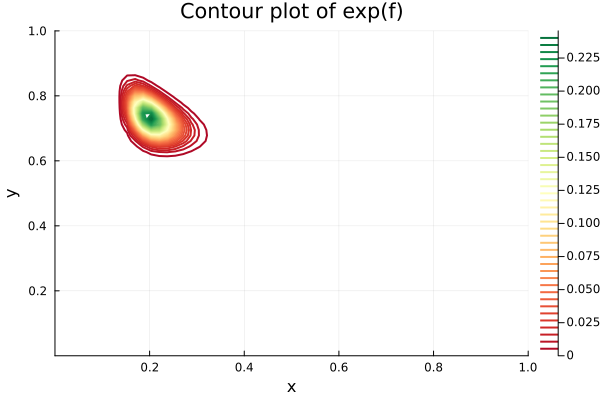

In [210]:
function ener(p)
    mu = sol_analitica(p) 
    likelihood = exp(mean(logpdf.(Normal.(mu,1), Crecimiento)) *1E-3)
    prior = exp((logpdf(Beta(2,2), p[1]) + logpdf(Beta(2,2), p[2]))*1E-2)
    return  likelihood*prior
end
ran = range(1E-8, 1.0, length=N)
contour2 = contour(ran, ran, [ener([i, j]) for j in ran, i in ran], levels=45, 
    linewidth=2, color=:RdYlGn, xlabel="x",ylabel="y", title="Contour plot of exp(f)")
#savefig("4_RB_contours.png")

In [206]:
samples, allsamples, probabilities, MAP, CM, rateAlpha = MHRW(ener,2,[0.9,0.1],0.005,2000)

([0.9 0.8271508275206214 … 0.2059025341732255 0.2059025341732255; 0.1 0.10012403371044301 … 0.738791529205696 0.738791529205696], [0.9 0.8271508275206214 … 0.2059025341732255 0.2059025341732255; 0.1 0.10012403371044301 … 0.738791529205696 0.738791529205696;;; 0.9 0.8271508275206214 … 0.2143425987980122 0.17864284620102394; 0.1 0.10012403371044301 … 0.8294068296675878 0.900369602053981], [5.306180816820982e-61, 5.653610412881218e-61, 5.653610412881218e-61, 5.653610412881218e-61, 5.653610412881218e-61, 2.130960521055086e-58, 2.130960521055086e-58, 3.276313865935801e-36, 1.174186758940896e-25, 3.8562510173478424e-24  …  0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698, 0.2347193849859698], [0.20005890131377788, 0.7364634231945713], [0.21619327595535429, 0.7257751562096734], 0.2726363181590795)

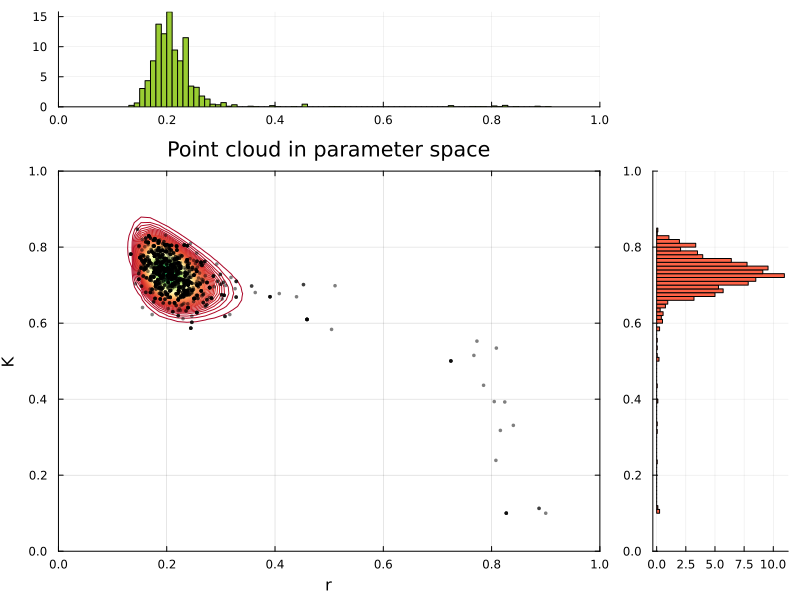

In [207]:
xhist = samples[1, :]
yhist = samples[2, :]

sxy = contour(ran, ran, [ener((i, j)) for j in ran, i in ran], levels=100, linewidth=1, color=:RdYlGn,xlim=(0.0,1.0),ylim=(0.0,1.0))
sxy = scatter!(xhist, yhist, markersize=2, title="Point cloud in parameter space", color="black", alpha=0.5,
    xlabel="r", ylabel="K", border=:box,colorbar=false)
hx = histogram(xhist,color=:yellowgreen,xlim=(0.0,1.0),normalize=:true)
hy = histogram(yhist, orientation=:horizontal,ylim=(0.0,1.0),color=:tomato,normalize=:true)
p0 = Plots.Plot()
cuadricula = grid(2,2, heights=(0.2,0.8), widths=(0.8,0.2))
plot(hx, p0, sxy, hy, legend=:none, layout=cuadricula,size=(800,600))


In [211]:
int1 = MCIntegration(mean(samples, dims=1))

([0.0181812846922339, 0.006060428230744652, 0.0030302141153722983, 0.0018181284692234123, 0.004882322437213149, 0.0034873731694379795, 0.005524221288997877, 0.009133873507977841, 0.009170849221015354, 0.008741023127512237  …  6.879276376325905e-7, 6.87236947294334e-7, 6.865472965134067e-7, 6.858586834024294e-7, 6.851711058519783e-7, 6.844845615860962e-7, 6.837990487174039e-7, 6.83114565191989e-7, 6.824311089004276e-7, 6.817486777888071e-7], -1.2695805440962604)

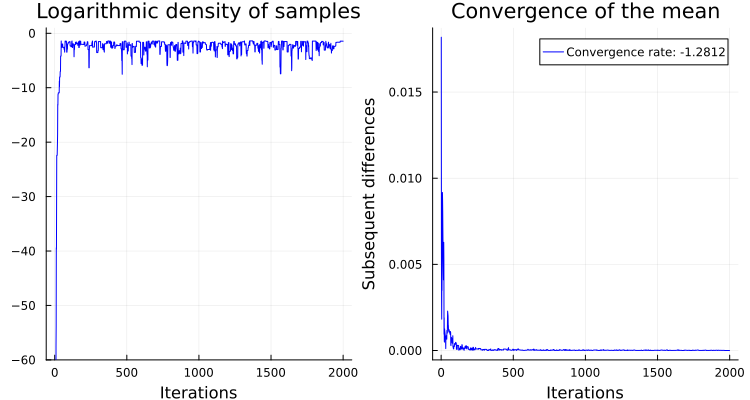

In [212]:
p01 = plot(log.(probabilities),xlabel="Iterations",label="", title="Logarithmic density of samples",color=:blue,ylim=(-60,1))
p02 = plot(int1[1],label="Convergence rate: -1.2812",title="Convergence of the mean",xlabel="Iterations",ylabel="Subsequent differences",
color=:blue)

plot(p01,p02,layout=(1,2),size = (750,400))

In [213]:
allsamples[:,1:10,:]

2×10×2 Array{Float64, 3}:
[:, :, 1] =
 0.9  0.827151  0.827151  0.827151  0.827151  …  0.807945  0.816225  0.840174
 0.1  0.100124  0.100124  0.100124  0.100124     0.239002  0.317793  0.331118

[:, :, 2] =
 0.9  0.827151   0.774745   0.78637     …  0.807945  0.816225  0.840174
 0.1  0.100124  -0.0357311  0.00440202     0.239002  0.317793  0.331118

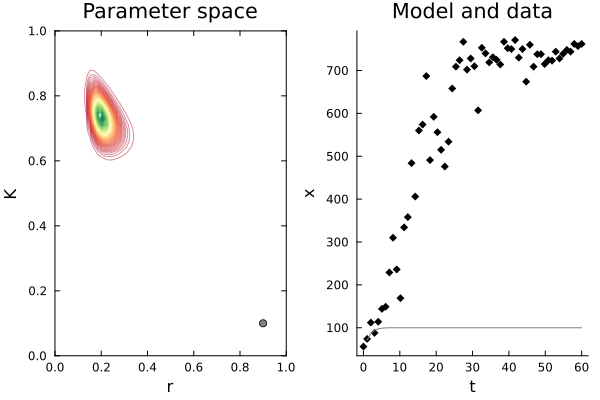

In [214]:
x = samples[1, :]
y = samples[2, :]


Left = contour(ran, ran, [ener((i, j)) for j in ran, i in ran], levels=100, linewidth=1, color=:RdYlGn,xlim=(0.0,1.0),ylim=(0.0,1.0),
     title="Parameter space", alpha=0.45,xlabel="r", ylabel="K", border=:box,colorbar=false,grid=false)

Left = scatter!([allsamples[1,1,1]],[allsamples[2,1,1]],color=:gray,label="")




Right = scatter(range(0.0, 60.0, length=N), Crecimiento,title="Model and data", label=false,grid=false,color=:black, marker=:diamond,
        xlabel="t",ylabel="x")

Right = plot!(range(1.0, 60.0, length=N),sol_analitica(allsamples[:,1,1]), color=:gray, label="")


Both = plot(Left, Right,layout=(1,2))



